# moleculeScreening
## This script was created to read in a SMILES string generated by the user and output pi conjugation information as well as provides a basic screening of logP

# Inport modules

In [1]:
# -*- coding: utf-8 -*-
"""
Created on Thu Jun 10 20:38:57 2021

@author: GERMANBARCENAS
"""

#%% Modules
import rdkit
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem import rdDistGeom as molDG
from rdkit.Chem import rdDepictor
from rdkit.Chem import Crippen
rdDepictor.SetPreferCoordGen(True)
IPythonConsole.ipython_useSVG=True
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.warning')
from matplotlib.colors import ColorConverter
rdDepictor.SetPreferCoordGen(True)
from IPython.display import SVG

# SMILES Input and prepare SMILES for rdkit

## the variable m will read in a SMILES string 

In [2]:
smiles='c1ccc(-c2ccccc2)cc(-O-C-C=N)1'
conjchaintest='c1ccccc1C=C-C(CC=C-C=C-C=Cc2ccccc2)CC-C=CCC=C-C=C' # this doesn't seem to be used any where
m=Chem.MolFromSmiles(smiles)
originalSanitized=Chem.SanitizeMol(m,catchErrors=True) # Do we really want to surpress the errors? Also originalSanitized is never used so no reason to store it
supp=Chem.ResonanceMolSupplier(m)

# Generate lists of conjugated atoms and bonds

In [4]:
conjugatedGroupNumber=supp.GetNumConjGrps()
conjugatedAtoms=[] # This doesn't seem to be used for any part of the calculation
conjugatedBonds=[] # This doesn't seem to be used for any part of the calculation
conjugatedAtomsList= [[] for i in range(conjugatedGroupNumber+1)] # This doesn't seem to be used for any part of the calculation
conjugatedBondsList= [[] for i in range(conjugatedGroupNumber+1)]
for idx,bond in  enumerate(m.GetBonds()): # idx is never used so no reason to enumerate
    if bond.GetIsConjugated()==True:
        a1=bond.GetBeginAtomIdx()
        a2=bond.GetEndAtomIdx()
        conjugatedAtoms.append([a1,a2])
        conjugatedBondIndex=m.GetBondBetweenAtoms(a1,a2).GetIdx()
        conjugatedBonds.append(conjugatedBondIndex)
        conjugatedGroup=supp.GetBondConjGrpIdx(conjugatedBondIndex)
        conjugatedAtomsList[conjugatedGroup].append([a1,a2])
        conjugatedBondsList[conjugatedGroup].append(conjugatedBondIndex)
        
conjugatedBondsList.sort(key=len,reverse=True)
conjugatedAtomsList.sort(key=len,reverse=True)
ConjugationTotalCount=len(conjugatedBondsList[0])

# Generate 2D Geometry to find distances

In [5]:
rdDepictor.Compute2DCoords(m)

chainMap={} # is this variable needed?
chain=Chem.PathToSubmol(m,conjugatedBondsList[0],atomMap=chainMap)

originalSanitized=Chem.SanitizeMol(chain,catchErrors=True) # Do really want to surpress errors?
distances=Chem.GetDistanceMatrix(chain)
maxDistances = [max(i) for i in distances]
maxPiDistance=max(maxDistances)


# logP from the Crippen method

In [6]:
logP=Chem.Crippen.MolLogP(m,includeHs=True)
logPResults=round(logP,3)

# Results

In [9]:
print('Total \u03C0 conjugation bond count =',ConjugationTotalCount)
print("Longest bond distance in \u03C0 chain:",maxPiDistance)
print('log(P)=',logPResults)

Total π conjugation bond count = 14
Longest bond distance in π chain: 7.0
log(P)= 3.382


# Draw Figure to check that SMILES ran correctly with highlights to each conjugation group

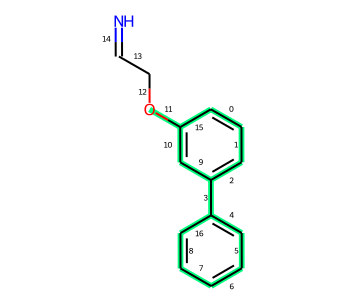

In [11]:
d2d = rdMolDraw2D.MolDraw2DSVG(350,300)
dos = d2d.drawOptions()
dos.setHighlightColour((0,1,0.5))
dos.atomHighlightsAreCircles = True
dos.fillHighlights=False
#d2d.drawOptions().addAtomIndices=True
d2d.drawOptions().addBondIndices=True
d2d.DrawMolecule(m,highlightBonds=conjugatedBonds,highlightAtoms=[])
d2d.FinishDrawing()
SVG(d2d.GetDrawingText())
#d2d.GetDrawingText()